In [1]:
from langchain_huggingface import HuggingFaceEmbeddings

## Load dumped vector stores

In [2]:
embeddings = HuggingFaceEmbeddings(
    model_name="jinaai/jina-embeddings-v3",
    model_kwargs={
        "device":'cuda',
        "trust_remote_code": True
    })

flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn is not installed. Using PyTorch native attention implementation.
flash_attn i

In [3]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore.load("vector_store.dump", embeddings)

## LLM

In [4]:
from langchain_huggingface import ChatHuggingFace, HuggingFacePipeline
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
    load_in_8bit=True
)

llm = HuggingFacePipeline.from_model_id(
    model_id="janhq/Jan-v1-4B",
    task="text-generation",
    pipeline_kwargs=dict(max_new_tokens=4096),
    model_kwargs={"quantization_config": quantization_config},
)

chat_model = ChatHuggingFace(llm=llm)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'min_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'min_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Device set to use cuda:0


## RAG

In [5]:
from langchain import hub
prompt = hub.pull("rlm/rag-prompt")

In [6]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [7]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = chat_model.invoke(messages)
    return {"answer": response.content}

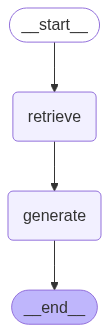

In [8]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

### Test the RAG

In [9]:
result = graph.invoke({"question": "What are the major factors causing poverty in MENA region?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

Context: [Document(id='3166283d-079a-4c0b-b15c-c27acf652521', metadata={'producer': 'Adobe PDF Library 15.0', 'creator': 'Adobe InDesign 15.1 (Macintosh)', 'creationdate': '2024-10-04T09:08:57+05:30', 'author': 'The World Bank Group', 'moddate': '2024-10-04T09:18:42+05:30', 'title': 'The Poverty, Prosperity, and Planet Report 2024; Overview', 'trapped': '/False', 'source': '../example_data/PPPR 2024 - Overview.pdf', 'total_pages': 66, 'page': 49, 'page_label': '34', 'start_index': 1818}, page_content='regions and country groupings circa 2021. For more information on the multidimensional poverty measure and its \ncomponents, see chapter 1 of the full report. Panel b: the sample consists of 45 countries that have data both for \n2010 and 2019. these countries represent 52 percent of the population in idA and 63 percent of the population in \nnon-idA countries. the variables used to compute the risk indicator for the years 2010 and 2019 differ slightly from \nthe risk indicator for the ye